In [1]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from deap import base, creator, tools, algorithms
import random
import numpy as np

In [3]:
# Generate a larger dataset with teachers, subjects, rooms, and time slots
teachers = [f"T{num}" for num in range(1, 11)]  # 10 teachers
subjects = [f"S{num}" for num in range(1, 8)]   # 7 subjects
rooms = [f"R{num}" for num in range(1, 6)]      # 5 rooms
time_slots = [
    f"{day} {hour}"
    for day in ["Mon", "Tue", "Wed", "Thu", "Fri"]
    for hour in ["9AM-10AM", "10AM-11AM", "11AM-12PM"]
]  # 15 time slots


In [4]:
# Enhanced teacher-subject mapping with specialization levels
teacher_subject_map = {
    "T1": {"S1": 0.9, "S2": 0.7},
    "T2": {"S2": 0.8, "S3": 0.9},
    "T3": {"S4": 0.9, "S5": 0.6},
    "T4": {"S1": 0.6, "S3": 0.8},
    "T5": {"S5": 0.9, "S6": 0.7},
    "T6": {"S2": 0.7, "S4": 0.8},
    "T7": {"S6": 0.9, "S7": 0.8},
    "T8": {"S3": 0.7, "S7": 0.9},
    "T9": {"S1": 0.8, "S5": 0.7},
    "T10": {"S4": 0.9, "S6": 0.8}
}


In [5]:
# Generate all possible class combinations
possible_classes = [
    (teacher, subject, room, time_slot)
    for teacher in teachers
    for subject in teacher_subject_map.get(teacher, {}).keys()
    for room in rooms
    for time_slot in time_slots
]

In [6]:
# Define constants
NUM_CLASSES = 45  # Number of classes to schedule

In [7]:
# Define fitness and individual representation
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize penalties
creator.create("Individual", list, fitness=creator.FitnessMin)

In [8]:
toolbox = base.Toolbox()

In [9]:
# Attribute generator: Randomly select a class
toolbox.register("attr_class", lambda: random.choice(possible_classes))

In [10]:
# Individual generator: Create individuals with a fixed number of classes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_class, n=NUM_CLASSES)

In [11]:
# Population generator: Create a population of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [50]:
# Comprehensive Evaluation Function
def evaluate(individual,teachers):
    penalty = 0
    teacher_schedule = {}
    room_schedule = {}
    teacher_daily_classes = {teacher: {} for teacher in teachers}
    subject_daily_distribution = {}

    # Hard Constraints Checking
    for i, class_data in enumerate(individual):
        teacher, subject, room, time_slot = class_data
        day = time_slot.split()[0]

        # Hard Constraint 1: Teacher Qualification
        if subject not in teacher_subject_map.get(teacher, {}):
            penalty += 30  # High penalty for unqualified teaching
        else:
            # Reduce penalty based on specialization level
            penalty += max(0, 20 * (1 - teacher_subject_map[teacher].get(subject, 0)))

        # Hard Constraint 2: No double booking for teacher
        if (teacher, time_slot) in teacher_schedule:
            penalty += 30
        else:
            teacher_schedule[(teacher, time_slot)] = True

        # Hard Constraint 3: No room double booking
        if (room, time_slot) in room_schedule:
            penalty += 25
        else:
            room_schedule[(room, time_slot)] = True

        # Soft Constraints
        # Track daily classes for teachers
        if day not in teacher_daily_classes[teacher]:
            teacher_daily_classes[teacher][day] = []
        teacher_daily_classes[teacher][day].append((subject, time_slot))

        # Track subject distribution
        if day not in subject_daily_distribution:
            subject_daily_distribution[day] = {}
        if subject not in subject_daily_distribution[day]:
            subject_daily_distribution[day][subject] = []
        subject_daily_distribution[day][subject].append(teacher)

    # Soft Constraint: Balanced Teaching Load
    for teacher, daily_schedule in teacher_daily_classes.items():
        # Prefer balanced distribution of classes
        daily_class_counts = [len(classes) for classes in daily_schedule.values()]
        if daily_class_counts:
            load_variance = np.var(daily_class_counts)
            penalty += load_variance * 5

    # Soft Constraint: Subject Distribution
    for day, subjects in subject_daily_distribution.items():
        for subject, teachers in subjects.items():
            # Prefer diverse teaching for each subject
            if len(set(teachers)) < 2:
                penalty += 10

    return penalty,


In [51]:
toolbox.register("evaluate", evaluate, teachers=teachers)

In [52]:
# Validated Crossover
def validated_crossover(parent1, parent2):
    child1, child2 = tools.cxTwoPoint(parent1, parent2)

    def resolve_conflicts(child):
        seen = set()
        for i, class_data in enumerate(child):
            teacher, subject, room, time_slot = class_data
            teacher_time_key = (teacher, time_slot)
            if teacher_time_key in seen:
                new_time_slot = random.choice([ts for ts in time_slots if ts != time_slot])
                child[i] = (teacher, subject, room, new_time_slot)
            seen.add(teacher_time_key)
        return child

    return resolve_conflicts(child1), resolve_conflicts(child2)

In [53]:
toolbox.register("mate", validated_crossover)

In [54]:
# Targeted Mutation
def targeted_mutation(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            teacher, subject, room, time_slot = individual[i]
            # Ensure mutation respects subject specialization
            possible_subjects = list(teacher_subject_map.get(teacher, {}).keys())

            # Mutate time slot or room or subject
            mutation_type = random.choice(['time', 'room', 'subject'])

            if mutation_type == 'time':
                new_time_slot = random.choice([ts for ts in time_slots if ts != time_slot])
                individual[i] = (teacher, subject, room, new_time_slot)
            elif mutation_type == 'room':
                new_room = random.choice([r for r in rooms if r != room])
                individual[i] = (teacher, subject, new_room, time_slot)
            else:  # subject mutation
                if possible_subjects:
                    new_subject = random.choice(possible_subjects)
                    individual[i] = (teacher, new_subject, room, time_slot)

    return individual,


In [55]:
toolbox.register("mutate", targeted_mutation, indpb=0.2)

In [56]:
# Tournament Selection
toolbox.register("select", tools.selTournament, tournsize=3)

In [69]:
# Parameters for the genetic algorithm
population_size = 100
generations = 100
mutation_prob = 0.2
crossover_prob = 0.8

In [70]:
# Initialize population
population = toolbox.population(n=population_size)

In [71]:
# Track statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [72]:
# Run the genetic algorithm
population, log = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=crossover_prob,
    mutpb=mutation_prob,
    ngen=generations,
    stats=stats,
    verbose=True,
)

gen	nevals	min    	avg    
0  	100   	666.878	820.369
1  	98    	532.186	666.556
2  	82    	517.986	629.448
3  	76    	426.061	605.69 
4  	88    	426.061	601.117
5  	84    	426.061	584.389
6  	69    	426.061	564.518
7  	95    	451.193	566.761
8  	88    	455.769	570.419
9  	82    	425.397	547.611
10 	89    	386.999	549.787
11 	84    	396.11 	535.212
12 	92    	399.118	537.246
13 	81    	410.886	526.234
14 	89    	373.486	526.877
15 	88    	373.486	513.449
16 	84    	360.936	508.561
17 	80    	372.758	485.774
18 	80    	373.486	478.915
19 	91    	350.269	477.518
20 	88    	363.556	472.556
21 	92    	353.647	474.101
22 	79    	353.647	464.804
23 	85    	353.647	463.678
24 	74    	329.486	445.028
25 	82    	346.887	439.683
26 	83    	353.689	428.722
27 	85    	332.304	423.278
28 	89    	310.556	407.996
29 	87    	306.717	400.519
30 	85    	299.956	411.076
31 	85    	301.522	394.838
32 	87    	299.956	393.391
33 	90    	301.522	385.411
34 	80    	276.749	357.96 
35 	87    	267.397	339.883
3

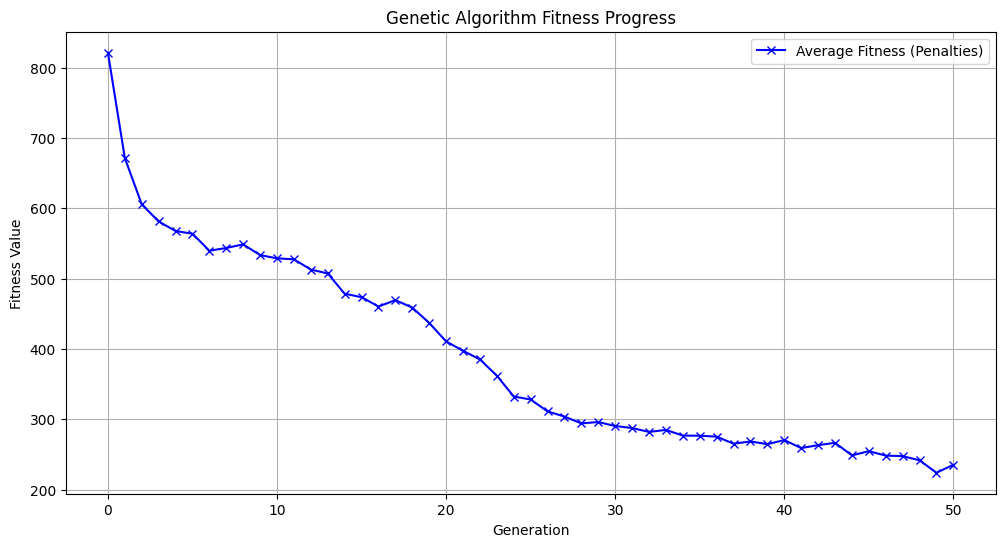

In [61]:
# Plot fitness progress
plt.figure(figsize=(12, 6))
gen = log.select("gen")
avg_fitness = log.select("avg")
plt.plot(gen, avg_fitness, label="Average Fitness (Penalties)", color="blue", marker="x")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Genetic Algorithm Fitness Progress")
plt.legend()
plt.grid()
plt.show()

In [62]:
# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]

In [63]:
# Organize timetable
timetable = {}
for class_data in best_individual:
    teacher, subject, room, time_slot = class_data
    if time_slot not in timetable:
        timetable[time_slot] = []
    timetable[time_slot].append((teacher, subject, room))

In [64]:
# Function to sort time slots
def sort_time_slots(slot):
    # Example format: "Fri 11AM-12PM"
    days_order = ["Mon", "Tue", "Wed", "Thu", "Fri"]
    day, time = slot.split()
    start_time = time.split('-')[0]  # Get start time
    return (days_order.index(day), start_time)

In [65]:
# Sort the time slots
sorted_slots = sorted(timetable.keys(), key=sort_time_slots)


In [66]:
# Print the timetable, grouped by day
current_day = ""
for time_slot in sorted_slots:
    day, time = time_slot.split()
    if day != current_day:
        if current_day:
            print()  # Add a blank line between days
        current_day = day
        print(f"{day}:")
    print(f"  {time}:")
    for class_info in timetable[time_slot]:
        print(f"    Teacher: {class_info[0]}, Subject: {class_info[1]}, Room: {class_info[2]}")

Mon:
  10AM-11AM:
    Teacher: T5, Subject: S5, Room: R2
    Teacher: T8, Subject: S7, Room: R3
    Teacher: T2, Subject: S2, Room: R5
    Teacher: T6, Subject: S4, Room: R1
    Teacher: T4, Subject: S3, Room: R4
  11AM-12PM:
    Teacher: T2, Subject: S3, Room: R5
    Teacher: T9, Subject: S1, Room: R4
    Teacher: T7, Subject: S7, Room: R3
    Teacher: T4, Subject: S1, Room: R1
  9AM-10AM:
    Teacher: T9, Subject: S5, Room: R3
    Teacher: T1, Subject: S1, Room: R5
    Teacher: T6, Subject: S4, Room: R4
    Teacher: T4, Subject: S3, Room: R2
    Teacher: T10, Subject: S4, Room: R1

Tue:
  10AM-11AM:
    Teacher: T10, Subject: S4, Room: R4
    Teacher: T7, Subject: S6, Room: R3
    Teacher: T6, Subject: S4, Room: R5
  11AM-12PM:
    Teacher: T5, Subject: S6, Room: R4
    Teacher: T7, Subject: S7, Room: R2
    Teacher: T2, Subject: S2, Room: R5
    Teacher: T10, Subject: S4, Room: R1
  9AM-10AM:
    Teacher: T6, Subject: S2, Room: R2

Wed:
  10AM-11AM:
    Teacher: T5, Subject: S6, Roo

In [67]:
# Enhanced Heatmap Function
def create_enhanced_heatmap(individual):
    timetable_df = pd.DataFrame(columns=["Time Slot", "Room", "Teacher-Subject"])

    # Collect all classes into the timetable dataframe
    for class_data in individual:
        teacher, subject, room, time_slot = class_data
        timetable_df = pd.concat([timetable_df, pd.DataFrame({
            "Time Slot": [time_slot],
            "Room": [room],
            "Teacher-Subject": [f"{teacher} ({subject})"]
        })], ignore_index=True)

    # Handle duplicates by combining teacher-subject data for the same time slot and room
    timetable_df['Teacher-Subject'] = timetable_df.groupby(['Time Slot', 'Room'])['Teacher-Subject'].transform(lambda x: ', '.join(x))

    # Drop duplicates (keeping only one row for each Time Slot + Room combination)
    timetable_df = timetable_df.drop_duplicates(subset=['Time Slot', 'Room'])

    # Pivot table for heatmap visualization
    heatmap_data = timetable_df.pivot(index="Time Slot", columns="Room", values="Teacher-Subject")

    # Plot enhanced heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        data=heatmap_data.isnull(),  # Create a mask-like heatmap
        cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='gray'
    )

    # Annotate heatmap with Teacher-Subject information
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            value = heatmap_data.iloc[i, j]
            if not pd.isnull(value):
                plt.text(j + 0.5, i + 0.5, value,
                         ha='center', va='center', fontsize=10, color='black')

    plt.title("Enhanced Timetable Heatmap")
    plt.xlabel("Room")
    plt.ylabel("Time Slot")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

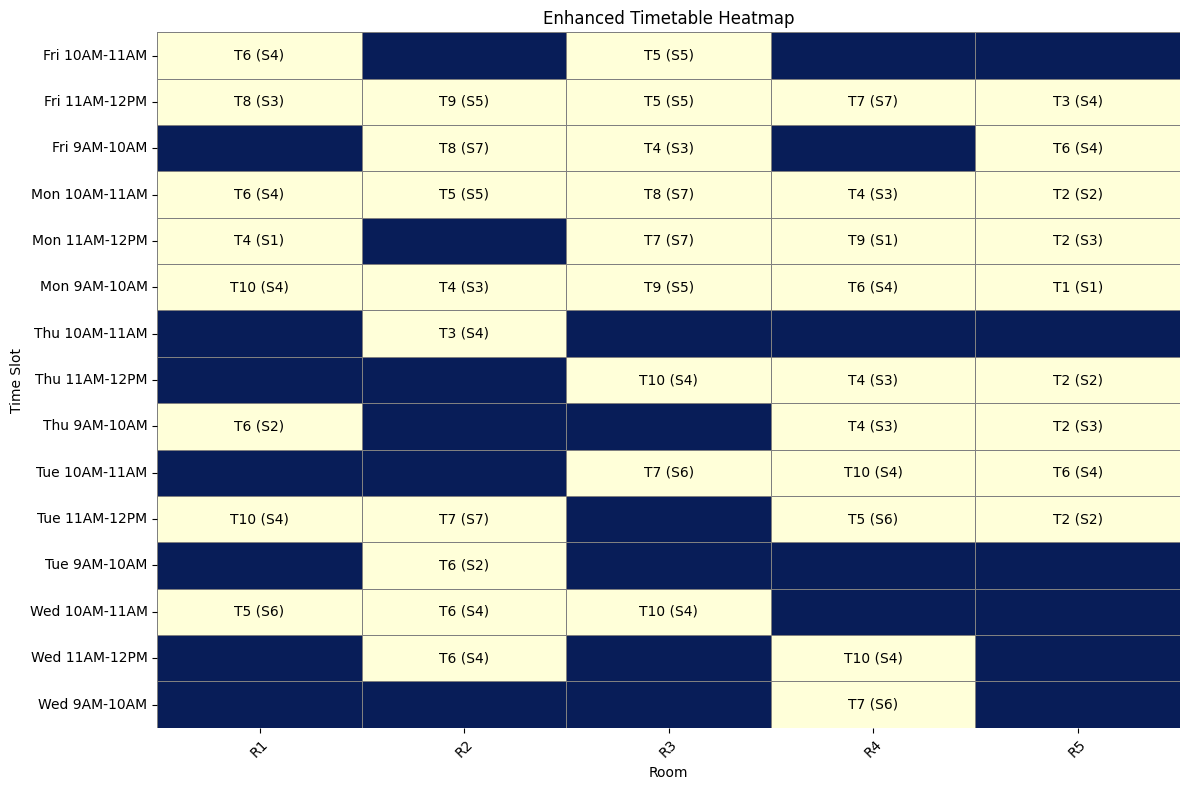

In [68]:
create_enhanced_heatmap(best_individual)